In [15]:
!pip install tabulate


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from tabulate import tabulate

In [49]:
# Load and clean data
df = pd.read_csv('Strawberry_Greenhouse.csv')

# Rename columns for consistency
df.rename(columns={
    "temparature": "temperature",
    "irTemparature": "irTemperature"
}, inplace=True)

# Convert time column
df["EnqueuedTimeUtc"] = pd.to_datetime(df["EnqueuedTimeUtc"])
df["hour"] = df["EnqueuedTimeUtc"].dt.hour
df["date"] = df["EnqueuedTimeUtc"].dt.date

C:\Users\findz\AppData\Local\Temp\ipykernel_11976\1388843301.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["EnqueuedTimeUtc"] = pd.to_datetime(df["EnqueuedTimeUtc"])


In [50]:
df.head()

,EnqueuedTimeUtc,deviceId,humidity,temperature,irTemperature,hour,date
0,2023-02-16 13:41:57,290EC1B,83,14,10,13,2023-02-16
1,2023-02-16 13:41:57,290EF53,83,14,12,13,2023-02-16
2,2023-02-16 13:41:58,290F190,88,13,12,13,2023-02-16
3,2023-02-16 13:41:59,290F39C,84,13,11,13,2023-02-16
4,2023-02-16 13:41:59,290F362,89,12,11,13,2023-02-16


In [51]:
df.isnull().sum()

EnqueuedTimeUtc    0
deviceId           0
humidity           0
temperature        0
irTemperature      0
hour               0
date               0
dtype: int64

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371079 entries, 0 to 371078
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   EnqueuedTimeUtc  371079 non-null  datetime64[ns]
 1   deviceId         371079 non-null  object        
 2   humidity         371079 non-null  int64         
 3   temperature      371079 non-null  int64         
 4   irTemperature    371079 non-null  int64         
 5   hour             371079 non-null  int32         
 6   date             371079 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(3), object(2)
memory usage: 18.4+ MB


In [53]:
df.describe()

,EnqueuedTimeUtc,humidity,temperature,irTemperature,hour
count,371079,371079.000000,371079.000000,371079.000000,371079.000000
mean,2023-10-20 04:37:26.731698944,70.233212,10.857437,14.718577,11.518652
min,2023-02-16 13:41:57,0.000000,-40.000000,-40.000000,0.000000
25%,2023-10-13 02:54:10,69.000000,8.000000,9.000000,6.000000
50%,2023-11-05 18:22:24,80.000000,11.000000,12.000000,12.000000
75%,2023-11-28 11:18:08,86.000000,15.000000,18.000000,18.000000
max,2023-12-22 09:25:57,100.000000,31.000000,59.000000,23.000000
std,NaN,27.817407,6.505052,15.454556,6.917348


In [54]:
df.columns

Index(['EnqueuedTimeUtc', 'deviceId', 'humidity', 'temperature',
       'irTemperature', 'hour', 'date'],
      dtype='object')

In [55]:
print("Device IDs:", df['deviceId'].unique())

Device IDs: ['290EC1B' '290EF53' '290F190' '290F39C' '290F362' '290ED74' '2908E26'
 '2909460' '290EAD5' '2908BE4' '2908FDA' '2908E30' '290940C' '2909467']


In [56]:
# Drop duplicates
df = df.drop_duplicates()

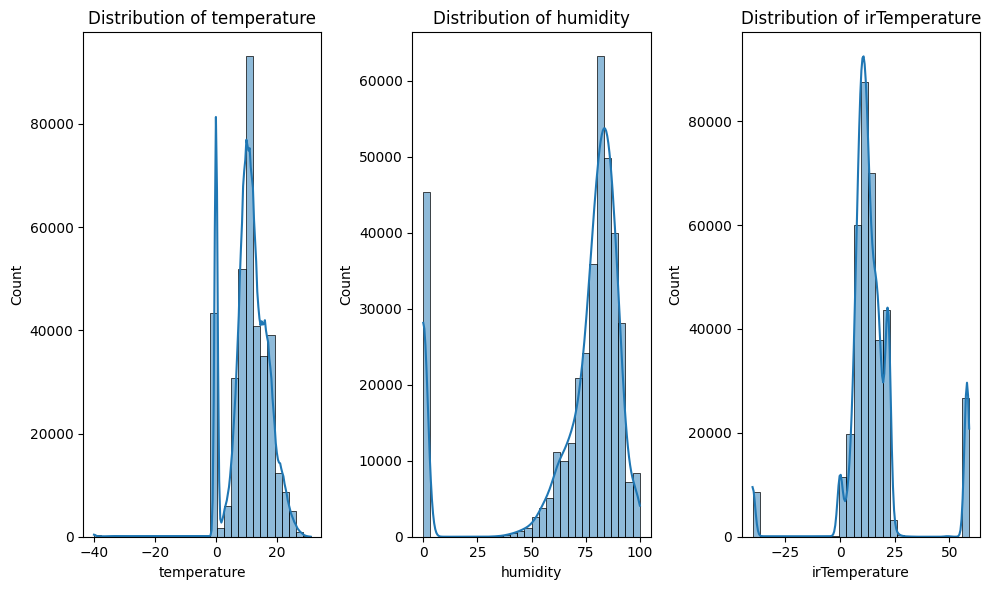

In [57]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(["temperature", "humidity", "irTemperature"]):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.savefig("kde_plots.png", dpi=300)
plt.show()

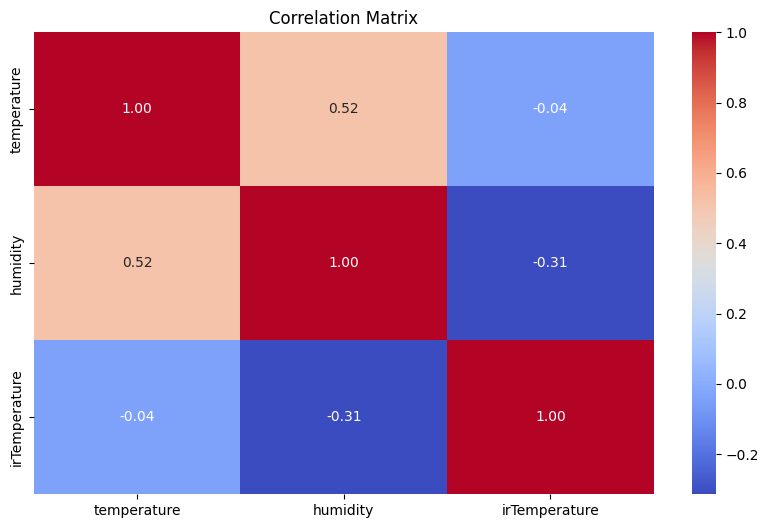

In [58]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[["temperature", "humidity", "irTemperature"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig("correlation_matrix.png", dpi=300)
plt.show()

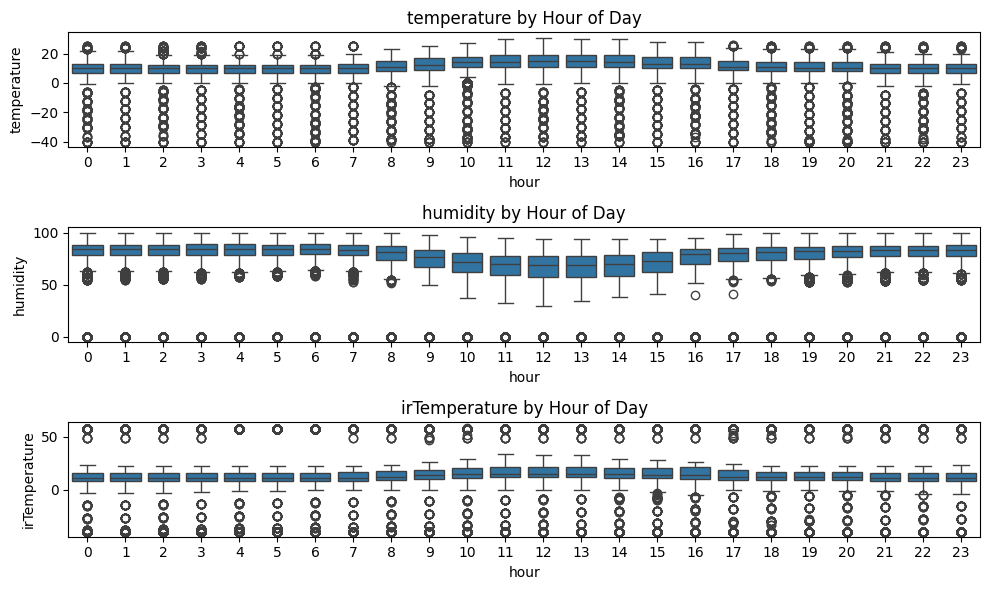

In [59]:
#Box plot by hour
plt.figure(figsize=(10, 6))
for i, col in enumerate(["temperature", "humidity", "irTemperature"]):
    plt.subplot(3, 1, i+1)
    sns.boxplot(data=df, x="hour", y=col)
    plt.title(f"{col} by Hour of Day")
plt.tight_layout()
plt.savefig("box_plots_before_cleaning.png", dpi=300)
plt.show()

In [60]:
# Anomoly detection
df["z_temp"] = zscore(df["temperature"])
df["z_irTemp"] = zscore(df["irTemperature"])
df["z_humidity"] = zscore(df["humidity"])

df["is_anomaly"] = ((df["z_temp"].abs() > 3) |
                    (df["z_irTemp"].abs() > 3) |
                    (df["z_humidity"].abs() > 3))

print(f"Total anomalies detected: {df['is_anomaly'].sum()}")

Total anomalies detected: 9605


In [61]:
# Remove anomalies
df_clean = df[~df["is_anomaly"]].copy()

# Optional: Reset index after filtering
df_clean.reset_index(drop=True, inplace=True)

# Confirm removal
print(f"Remaining data points after removing anomalies: {len(df_clean)}")

Remaining data points after removing anomalies: 361114


In [62]:
# Sensor-level statistics on cleaned data
device_stats_clean = df_clean.groupby("deviceId")[["temperature", "humidity", "irTemperature"]].agg(["mean", "std", "min", "max", "median"])

# Flatten multi-level column names
device_stats_clean.columns = ['_'.join(col) for col in device_stats_clean.columns]

# Display the result
print(device_stats_clean.head())

          temperature_mean  temperature_std  temperature_min  temperature_max  \
deviceId                                                                        
2908BE4          11.477288         4.629283                0               30   
2908E26          12.098878         4.510491                2               29   
2908E30          12.049617         4.517635                2               29   
2908FDA          11.628316         4.619694                1               30   
290940C           0.000000         0.000000                0                0   

          temperature_median  humidity_mean  humidity_std  humidity_min  \
deviceId                                                                  
2908BE4                 11.0      83.005838      8.811552            29   
2908E26                 11.0      81.826722      9.185352            38   
2908E30                 11.0      78.948459      8.981945            38   
2908FDA                 11.0      86.127605      9.162233

In [19]:
!pip install -q prettytable


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
from prettytable import PrettyTable

# Create table with column names
pt = PrettyTable()
pt.field_names = ["deviceId"] + list(device_stats_clean.columns)

# Add rows
for idx, row in device_stats_clean.iterrows():
    pt.add_row([idx] + list(row))

print(pt)

+----------+--------------------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+--------------+--------------+-----------------+--------------------+-------------------+-------------------+-------------------+----------------------+
| deviceId |  temperature_mean  |  temperature_std   | temperature_min | temperature_max | temperature_median |   humidity_mean   |    humidity_std    | humidity_min | humidity_max | humidity_median | irTemperature_mean | irTemperature_std | irTemperature_min | irTemperature_max | irTemperature_median |
+----------+--------------------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+--------------+--------------+-----------------+--------------------+-------------------+-------------------+-------------------+----------------------+
| 2908BE4  | 11.477287627610751 | 4.629282878285759  |       0.0       |       30.0  

C:\Users\findz\AppData\Local\Temp\ipykernel_11976\3333728403.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_df = sample_df[["temperature", "humidity", "irTemperature"]].rolling("1H").mean()


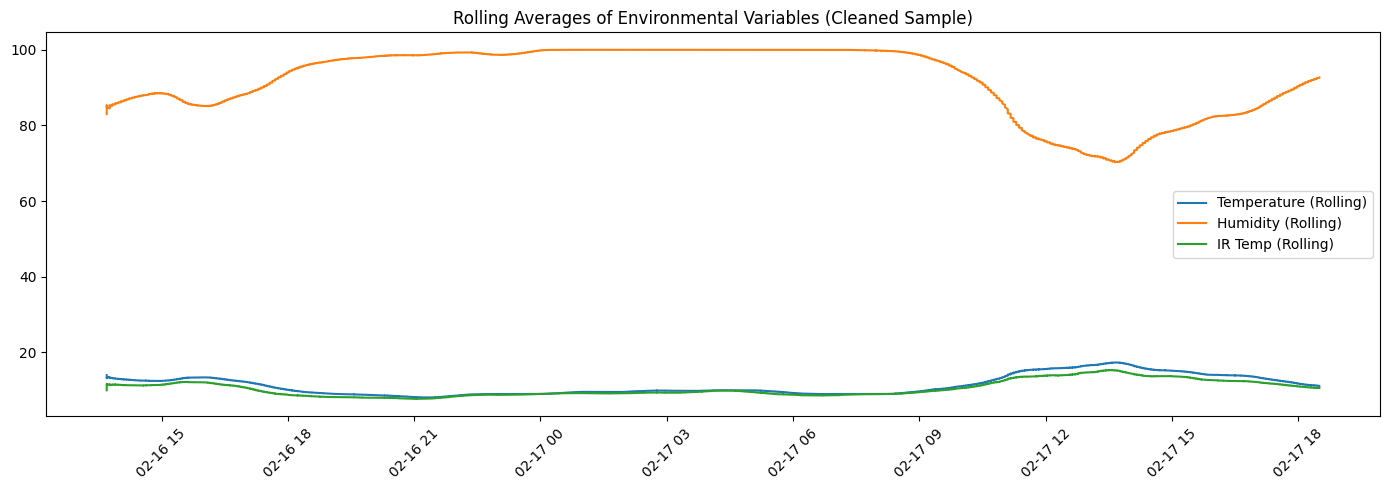

In [64]:
import matplotlib.pyplot as plt

# Ensure datetime type if not already
df_clean["EnqueuedTimeUtc"] = pd.to_datetime(df_clean["EnqueuedTimeUtc"])

# Sort and sample first 5000 entries
sample_df = df_clean.sort_values("EnqueuedTimeUtc").iloc[:5000].copy()
sample_df.set_index("EnqueuedTimeUtc", inplace=True)

# Compute 1-hour rolling averages
rolling_df = sample_df[["temperature", "humidity", "irTemperature"]].rolling("1H").mean()

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(rolling_df.index, rolling_df["temperature"], label="Temperature (Rolling)")
plt.plot(rolling_df.index, rolling_df["humidity"], label="Humidity (Rolling)")
plt.plot(rolling_df.index, rolling_df["irTemperature"], label="IR Temp (Rolling)")
plt.legend()
plt.title("Rolling Averages of Environmental Variables (Cleaned Sample)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("rolling_averages.png", dpi=300)
plt.show()

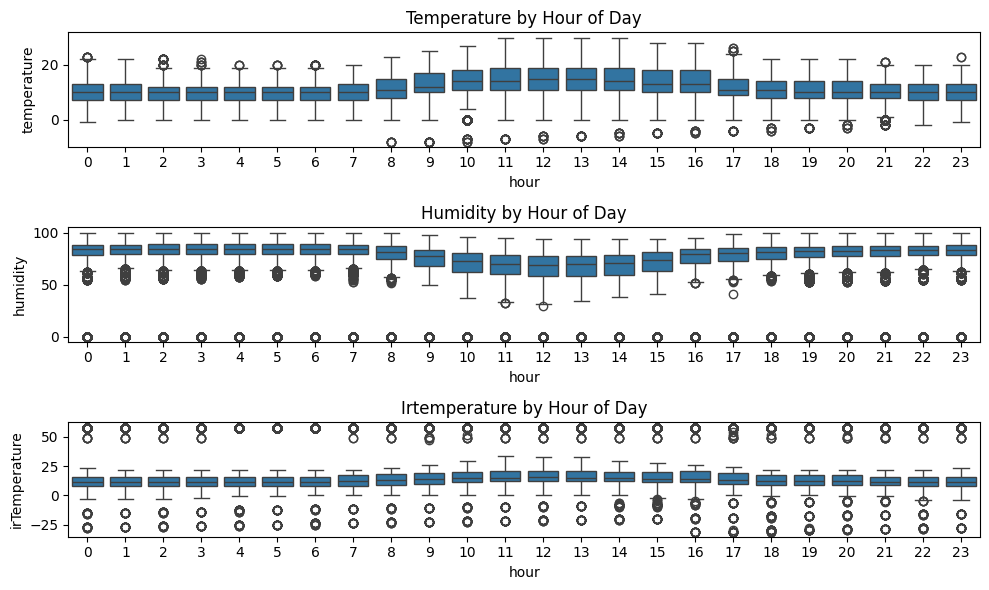

In [65]:
# Box plot by hour
plt.figure(figsize=(10, 6))
for i, col in enumerate(["temperature", "humidity", "irTemperature"]):
    plt.subplot(3, 1, i+1)
    sns.boxplot(data=df_clean, x="hour", y=col)
    plt.title(f"{col.capitalize()} by Hour of Day")
plt.tight_layout()
plt.savefig("boxplots_after_cleaning_data.png", dpi=300)
plt.show()

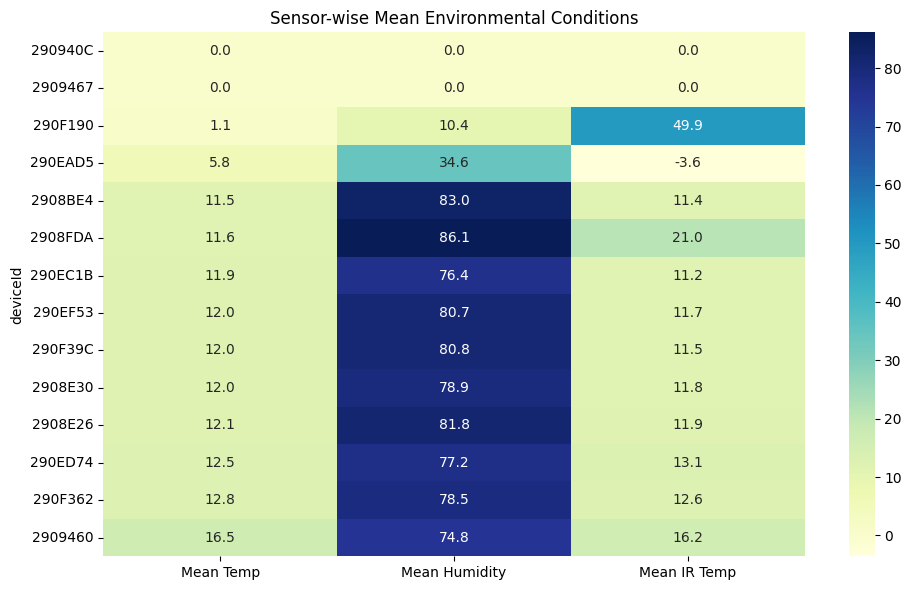

In [66]:
# Pivot tables for each variable
pivot_temp = df.pivot_table(index="deviceId", values="temperature", aggfunc="mean").sort_values("temperature")
pivot_humidity = df.pivot_table(index="deviceId", values="humidity", aggfunc="mean").reindex(pivot_temp.index)
pivot_irtemp = df.pivot_table(index="deviceId", values="irTemperature", aggfunc="mean").reindex(pivot_temp.index)

# Combine into a single DataFrame
sensor_matrix = pd.concat([pivot_temp, pivot_humidity, pivot_irtemp], axis=1)
sensor_matrix.columns = ["Mean Temp", "Mean Humidity", "Mean IR Temp"]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sensor_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Sensor-wise Mean Environmental Conditions")
plt.tight_layout()
plt.savefig("Sensor-wise_Mean_Environmental_Conditions.png", dpi=300)
plt.show()

### Research question 1

### What are the environmental conditions during high-irTemperature periods, and do they indicate potential heat stress for plants?

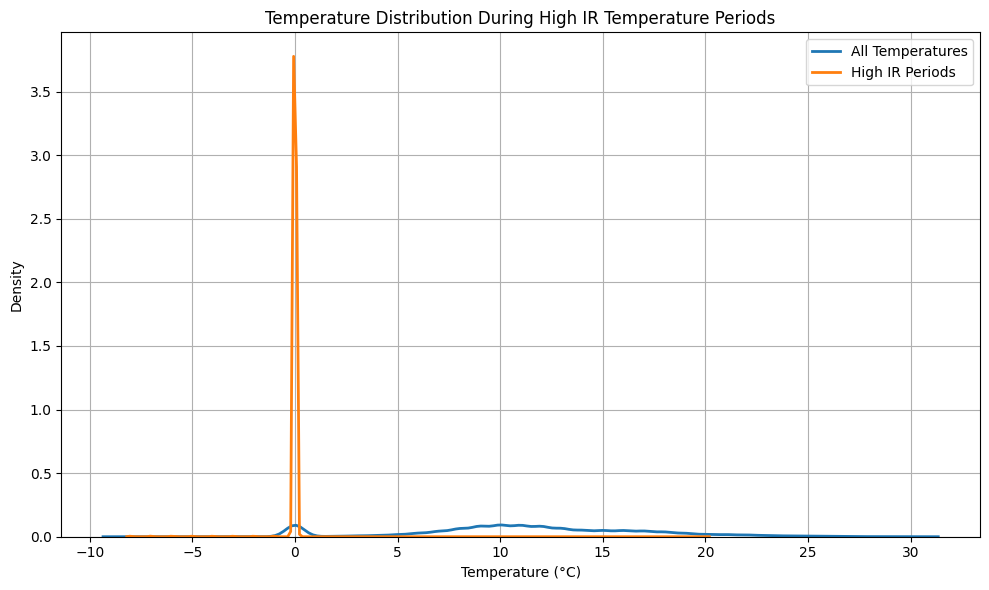

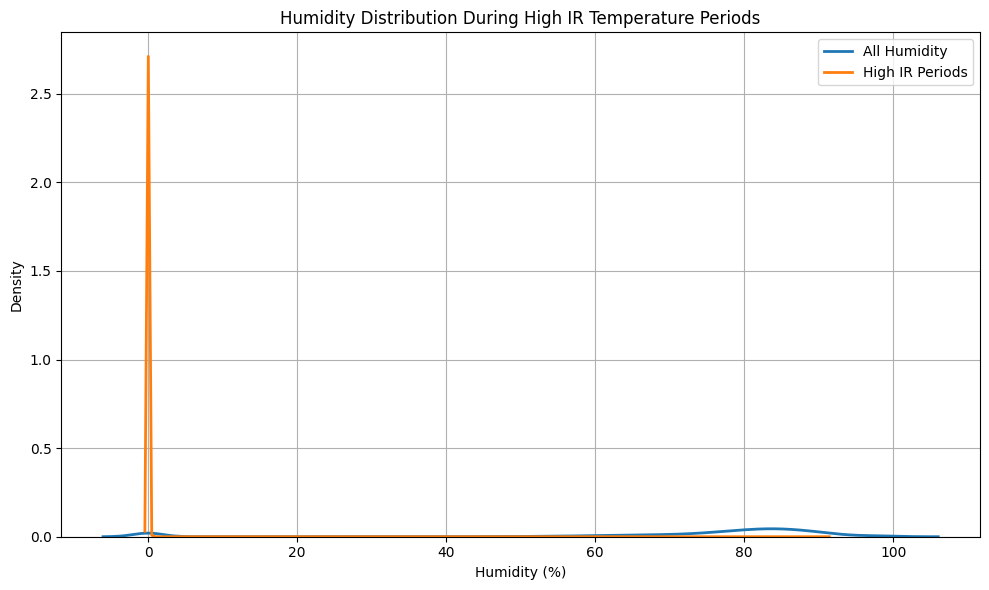

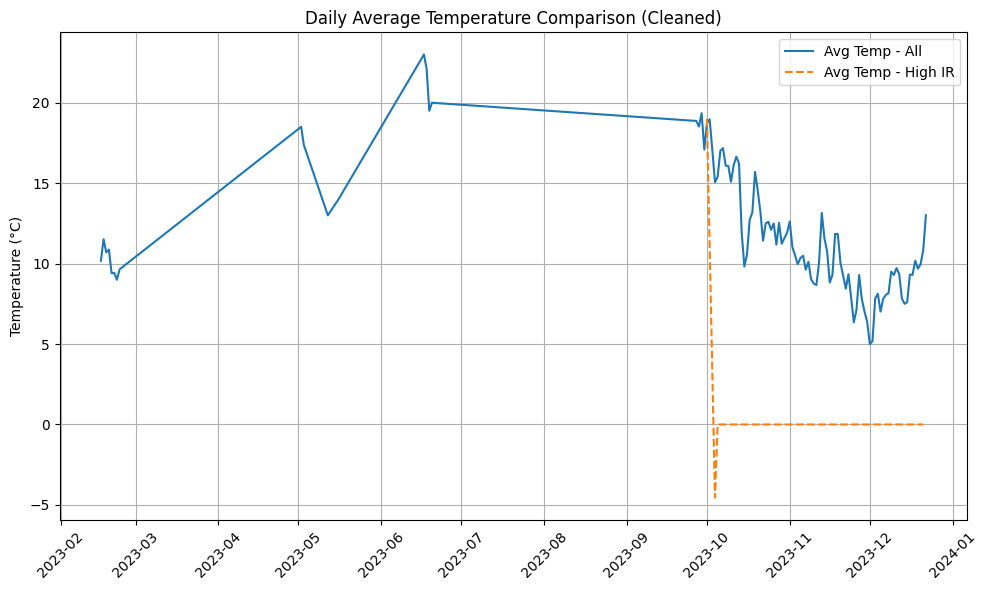

C:\Users\findz\AppData\Local\Temp\ipykernel_11976\1893649172.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_df = df_clean_sorted[["temperature", "humidity", "irTemperature"]].rolling("2H").mean()


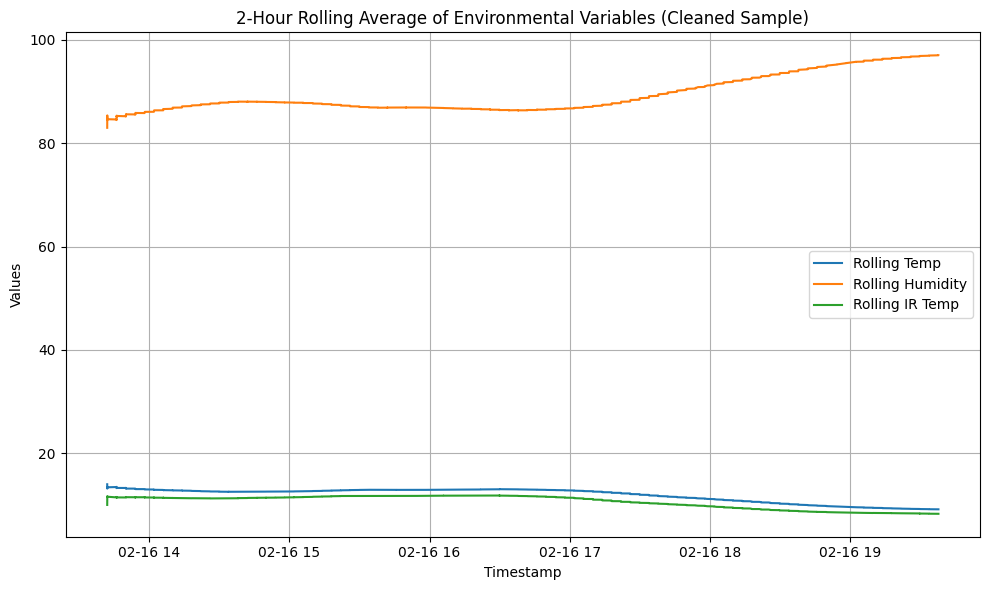

In [68]:
# Define high IR threshold: top 5% IR values
ir_threshold = df_clean["irTemperature"].quantile(0.95)
high_ir_df = df_clean[df_clean["irTemperature"] >= ir_threshold]

# --- KDE plots: Temperature ---
plt.figure(figsize=(10, 6))
sns.kdeplot(df_clean["temperature"], label="All Temperatures", linewidth=2)
sns.kdeplot(high_ir_df["temperature"], label="High IR Periods", linewidth=2)
plt.title("Temperature Distribution During High IR Temperature Periods")
plt.xlabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("temperature_kde_cleaned.png", dpi=300)
plt.show()

# --- KDE plots: Humidity ---
plt.figure(figsize=(10, 6))
sns.kdeplot(df_clean["humidity"], label="All Humidity", linewidth=2)
sns.kdeplot(high_ir_df["humidity"], label="High IR Periods", linewidth=2)
plt.title("Humidity Distribution During High IR Temperature Periods")
plt.xlabel("Humidity (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("humidity_kde_cleaned.png", dpi=300)
plt.show()

# --- Daily average comparison ---
daily_avg_all = df_clean.groupby("date")[["temperature", "humidity", "irTemperature"]].mean()
daily_avg_high_ir = high_ir_df.groupby("date")[["temperature", "humidity", "irTemperature"]].mean()

plt.figure(figsize=(10, 6))
plt.plot(daily_avg_all.index, daily_avg_all["temperature"], label="Avg Temp - All")
plt.plot(daily_avg_high_ir.index, daily_avg_high_ir["temperature"], label="Avg Temp - High IR", linestyle="--")
plt.xticks(rotation=45)
plt.title("Daily Average Temperature Comparison (Cleaned)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("daily_avg_temp_comparison_cleaned.png", dpi=300)
plt.show()

# --- 2-Hour Rolling Average ---
df_clean_sorted = df_clean.sort_values("EnqueuedTimeUtc").copy()
df_clean_sorted.set_index("EnqueuedTimeUtc", inplace=True)
rolling_df = df_clean_sorted[["temperature", "humidity", "irTemperature"]].rolling("2H").mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_df.index[:1000], rolling_df["temperature"].iloc[:1000], label="Rolling Temp")
plt.plot(rolling_df.index[:1000], rolling_df["humidity"].iloc[:1000], label="Rolling Humidity")
plt.plot(rolling_df.index[:1000], rolling_df["irTemperature"].iloc[:1000], label="Rolling IR Temp")
plt.title("2-Hour Rolling Average of Environmental Variables (Cleaned Sample)")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rolling_avg_environment_cleaned.png", dpi=300)
plt.show()

### Research question 2
How consistent are temperature and humidity conditions hour-by-hour across multiple days?

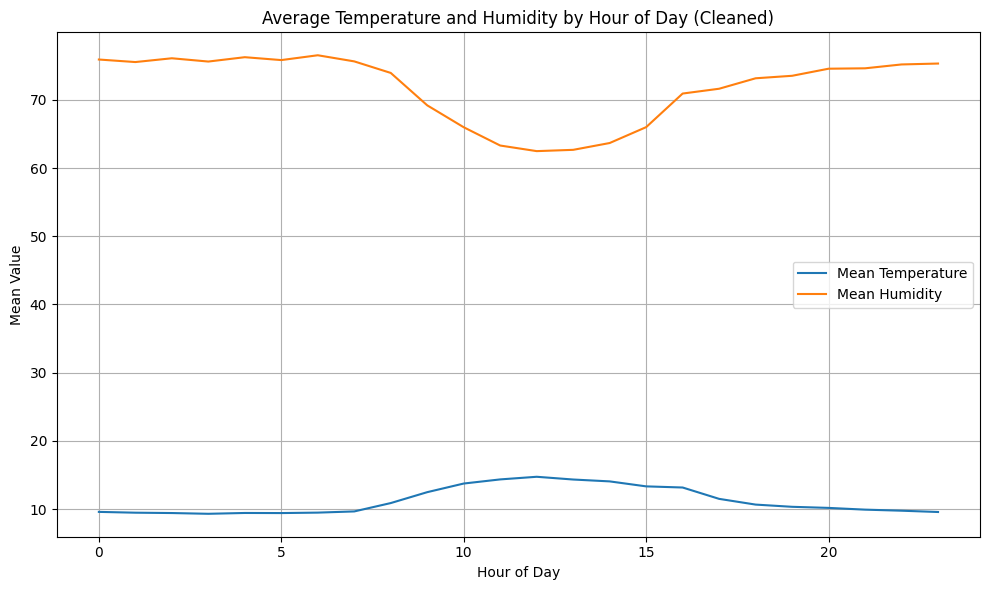

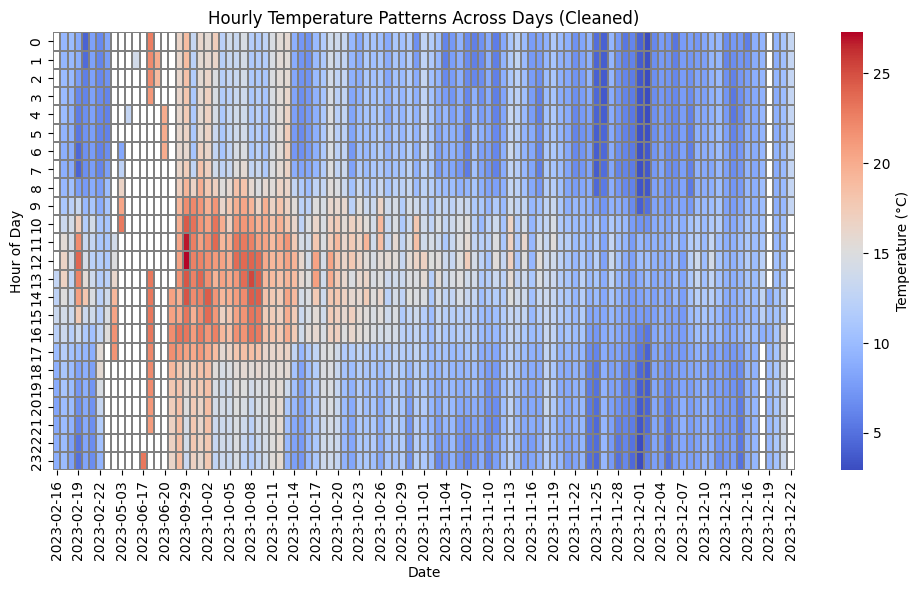

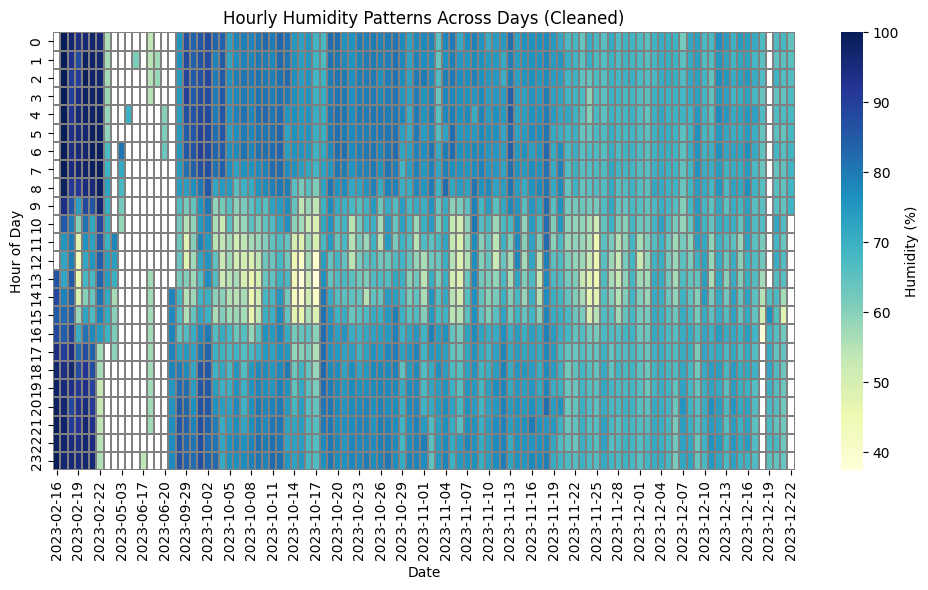

In [69]:
# 1. Hourly mean and standard deviation
hourly_stats = df_clean.groupby("hour")[["temperature", "humidity"]].agg(["mean", "std"]).reset_index()
hourly_stats.columns = ["hour", "temp_mean", "temp_std", "humidity_mean", "humidity_std"]

# 2. Pivot tables for temperature and humidity heatmaps
pivot_temp = df_clean.pivot_table(index="hour", columns="date", values="temperature", aggfunc="mean")
pivot_humidity = df_clean.pivot_table(index="hour", columns="date", values="humidity", aggfunc="mean")

# 3. Plot hourly mean temperature and humidity (line plot)
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_stats, x="hour", y="temp_mean", label="Mean Temperature")
sns.lineplot(data=hourly_stats, x="hour", y="humidity_mean", label="Mean Humidity")
plt.title("Average Temperature and Humidity by Hour of Day (Cleaned)")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("hourly_avg_temp_humidity_cleaned.png", dpi=300)
plt.show()

# 4. Heatmap of hourly temperature across days
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_temp, cmap="coolwarm", cbar_kws={'label': 'Temperature (°C)'}, 
            linewidths=0.3, linecolor='gray')
plt.title("Hourly Temperature Patterns Across Days (Cleaned)")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.savefig("hourly_temp_heatmap_cleaned.png", dpi=300)
plt.show()

# 5. Heatmap of hourly humidity across days
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_humidity, cmap="YlGnBu", cbar_kws={'label': 'Humidity (%)'}, 
            linewidths=0.3, linecolor='gray')
plt.title("Hourly Humidity Patterns Across Days (Cleaned)")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.savefig("hourly_humidity_heatmap_cleaned.png", dpi=300)
plt.show()

### Research question 3
Are there recurring deviations in temperature or humidity reported by specific sensors that do not align with overall greenhouse trends?

C:\Users\findz\AppData\Local\Temp\ipykernel_11976\179967909.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sensor_dev.sort_values("temp_dev_mean"), x="deviceId", y="temp_dev_mean", palette="coolwarm")


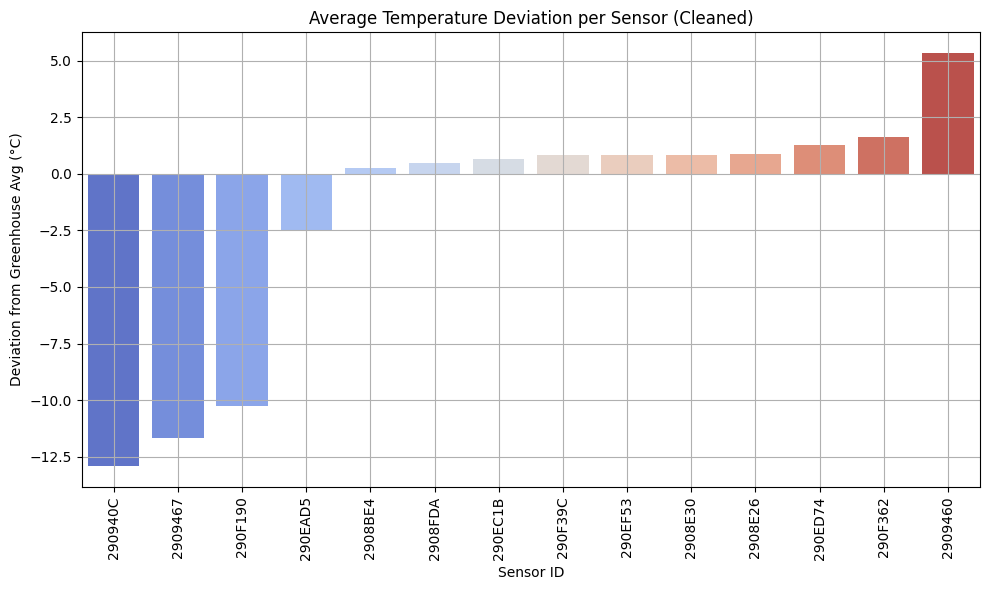

C:\Users\findz\AppData\Local\Temp\ipykernel_11976\179967909.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sensor_dev.sort_values("humidity_dev_mean"), x="deviceId", y="humidity_dev_mean", palette="YlGnBu")


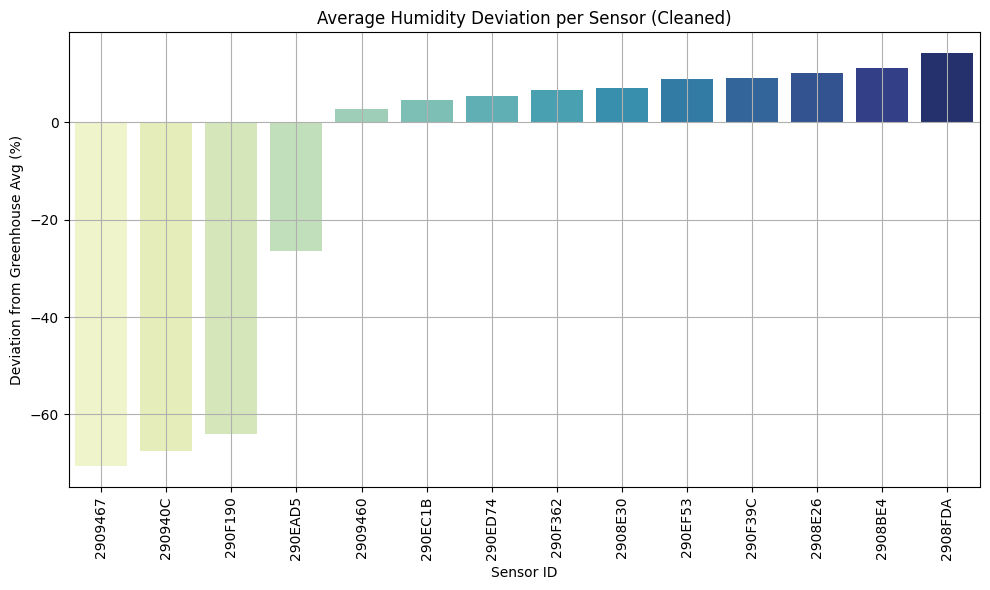

C:\Users\findz\AppData\Local\Temp\ipykernel_11976\179967909.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x="deviceId", y="temp_dev", palette="coolwarm")


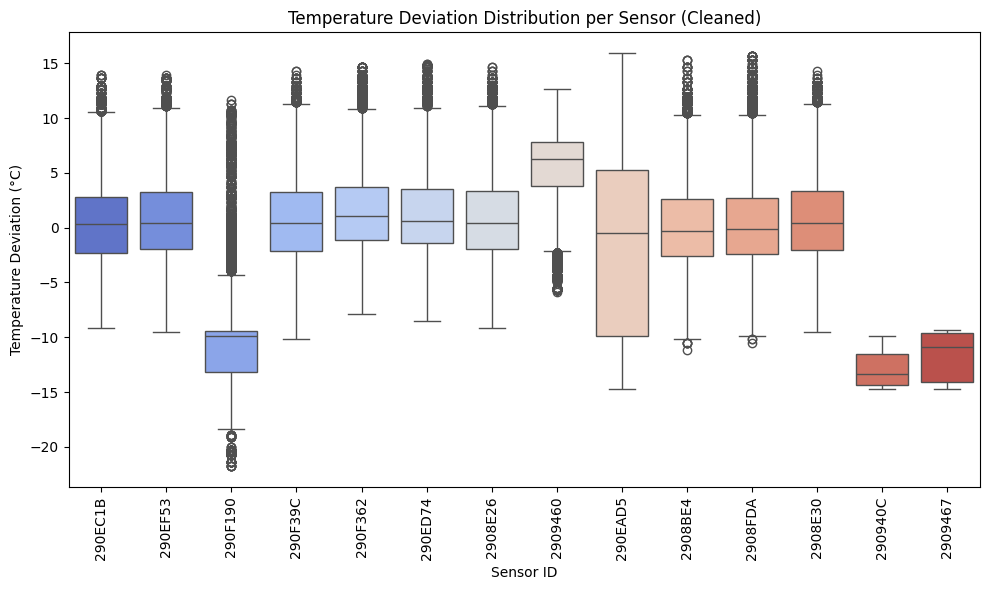

C:\Users\findz\AppData\Local\Temp\ipykernel_11976\179967909.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x="deviceId", y="humidity_dev", palette="YlGnBu")


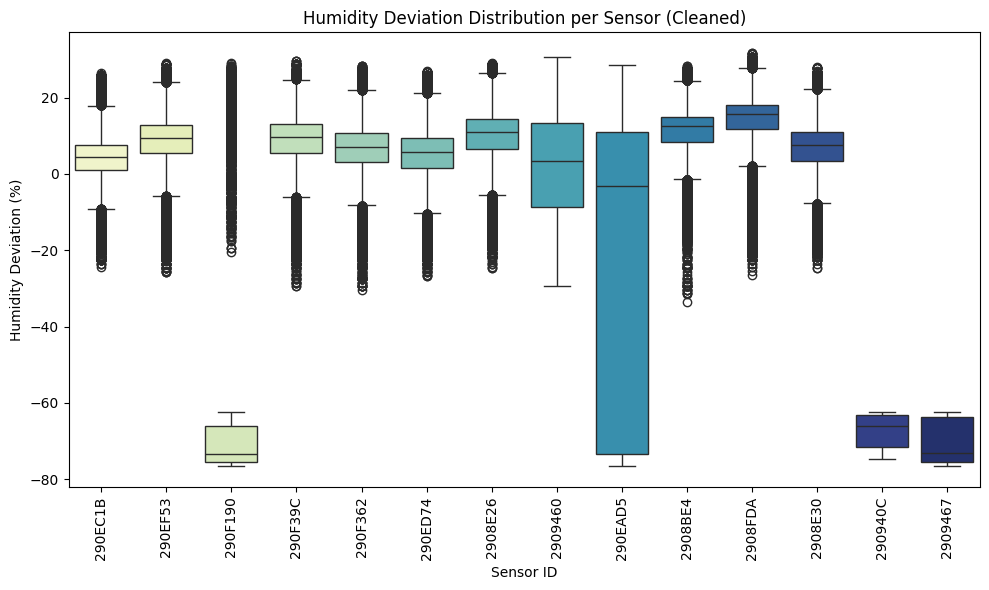

C:\Users\findz\AppData\Local\Temp\ipykernel_11976\179967909.py:69: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_dev = sensor_data[["temp_dev", "humidity_dev"]].rolling("3H").mean()


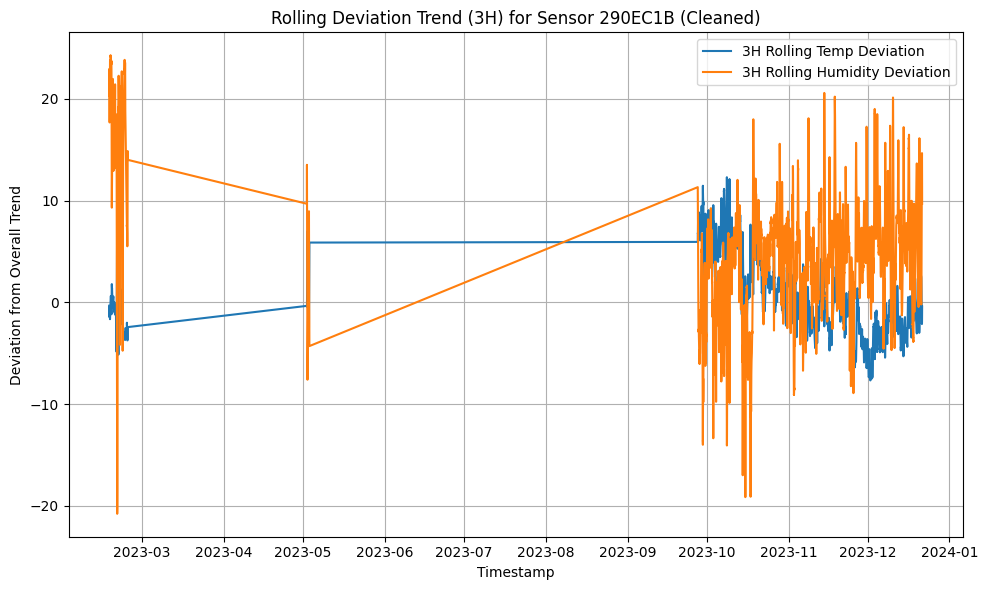

In [70]:
# Calculate hourly greenhouse-wide averages
overall_avg = df_clean.groupby("hour")[["temperature", "humidity"]].mean().rename(
    columns={"temperature": "temperature_overall", "humidity": "humidity_overall"}
).reset_index()

# Merge with cleaned dataframe
df_clean = df_clean.merge(overall_avg, on="hour", how="left")

# Compute deviation from hourly average
df_clean["temp_dev"] = df_clean["temperature"] - df_clean["temperature_overall"]
df_clean["humidity_dev"] = df_clean["humidity"] - df_clean["humidity_overall"]

# Compute average and std deviation by sensor
sensor_dev = df_clean.groupby("deviceId")[["temp_dev", "humidity_dev"]].agg(["mean", "std"]).reset_index()
sensor_dev.columns = ["deviceId", "temp_dev_mean", "temp_dev_std", "humidity_dev_mean", "humidity_dev_std"]

# 1. Bar plot: temperature deviation per sensor
plt.figure(figsize=(10, 6))
sns.barplot(data=sensor_dev.sort_values("temp_dev_mean"), x="deviceId", y="temp_dev_mean", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Average Temperature Deviation per Sensor (Cleaned)")
plt.xlabel("Sensor ID")
plt.ylabel("Deviation from Greenhouse Avg (°C)")
plt.tight_layout()
plt.grid(True)
plt.savefig("temp_deviation_per_sensor_cleaned.png", dpi=300)
plt.show()

# 2. Bar plot: humidity deviation per sensor
plt.figure(figsize=(10, 6))
sns.barplot(data=sensor_dev.sort_values("humidity_dev_mean"), x="deviceId", y="humidity_dev_mean", palette="YlGnBu")
plt.xticks(rotation=90)
plt.title("Average Humidity Deviation per Sensor (Cleaned)")
plt.xlabel("Sensor ID")
plt.ylabel("Deviation from Greenhouse Avg (%)")
plt.tight_layout()
plt.grid(True)
plt.savefig("humidity_deviation_per_sensor_cleaned.png", dpi=300)
plt.show()

# 3. Box plot: temperature deviations by sensor
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x="deviceId", y="temp_dev", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Temperature Deviation Distribution per Sensor (Cleaned)")
plt.xlabel("Sensor ID")
plt.ylabel("Temperature Deviation (°C)")
plt.tight_layout()
plt.savefig("temp_deviation_boxplot_cleaned.png", dpi=300)
plt.show()

# 4. Box plot: humidity deviations by sensor
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x="deviceId", y="humidity_dev", palette="YlGnBu")
plt.xticks(rotation=90)
plt.title("Humidity Deviation Distribution per Sensor (Cleaned)")
plt.xlabel("Sensor ID")
plt.ylabel("Humidity Deviation (%)")
plt.tight_layout()
plt.savefig("humidity_deviation_boxplot_cleaned.png", dpi=300)
plt.show()

# 5. Rolling average deviation plot for a selected sensor
selected_sensor_id = df_clean["deviceId"].unique()[0]
sensor_data = df_clean[df_clean["deviceId"] == selected_sensor_id].copy()
sensor_data.sort_values("EnqueuedTimeUtc", inplace=True)
sensor_data.set_index("EnqueuedTimeUtc", inplace=True)

rolling_dev = sensor_data[["temp_dev", "humidity_dev"]].rolling("3H").mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_dev.index, rolling_dev["temp_dev"], label="3H Rolling Temp Deviation")
plt.plot(rolling_dev.index, rolling_dev["humidity_dev"], label="3H Rolling Humidity Deviation")
plt.title(f"Rolling Deviation Trend (3H) for Sensor {selected_sensor_id} (Cleaned)")
plt.xlabel("Timestamp")
plt.ylabel("Deviation from Overall Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rolling_avg_deviation_sensor_cleaned.png", dpi=300)
plt.show()